In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats

From the WCRP assessment, Eq. (4.3) is 

$$\Delta T_{obs} = S_{hist} \frac{(\Delta F - \Delta N)}{F_{2\times CO_2}} + e$$ 

In [2]:
nsamp=100000 #change as needed
dT_error = np.random.normal(loc=0.00,scale=0.14/1.64,size=nsamp) #Assume error in dT is normally distributed
dT=1.0
dN = np.random.normal(0.60,0.3/1.64,size=nsamp)
F2x = np.random.normal(3.7,0.49/1.64,size=nsamp)


To allow for the correlation between CO$_2$ forcing part of $\Delta F$ and $F_{2\times CO_2}$ we decompose $\Delta F$ into its CO$_2$ and non-CO$_2$ constituent time series, and sample the latter independently of $F_{2\times CO_2}$ before recombining to obtain the samples $\Delta F$.  This means we need to know exactly what the CO2 and non-CO2 forcings were over this time period.  I use the values in hist_forc_out.txt, generated by Mark Webb using subroutine hist_forc, and put these in a python dictionary.

In [3]:
f=open("hist_forc_out.txt")
test=f.readlines()
f.close()

In [4]:
dF_CO2=float(test[-1].split(":")[-1])
rest=np.array(test[:-1])
baselines=rest[::5]
recents=rest[1::5]
unc_pos=rest[2::5]
unc_neg=rest[3::5]
other_forcings=[x.split("baseline")[0] for x in baselines]
forcing_dict={}
for i in range(len(other_forcings)):
    key=other_forcings[i]
    forcing_dict[key]={}
    devs=np.random.normal(0,1.0,size=nsamp)
    devscaled=np.zeros_like(devs)
    sigma_pos=float(unc_pos[i].split(":")[-1])
    forcing_dict[key]["sigma_pos"]=sigma_pos
    devscaled[np.where(devs>=0)]=devs[np.where(devs>=0)]*sigma_pos

    sigma_neg=float(unc_neg[i].split(":")[-1])
    forcing_dict[key]["sigma_neg"]=sigma_neg
    devscaled[np.where(devs<0)]=devs[np.where(devs<0)]*sigma_neg
    
    baseline=float(baselines[i].split(":")[-1])
    forcing_dict[key]["baseline"]=baseline
    
    recent=float(recents[i].split(":")[-1])
    forcing_dict[key]["recent"]=recent
    forcing_dict[key]["deviations"] = (recent-baseline)*(1+devscaled)
    
    
    
    

In [5]:
def generate_dF():
    all_forcings=np.zeros((len(other_forcings),nsamp))
    i=0
    for key in other_forcings:
        devs=np.random.normal(0,1.0,size=nsamp)
        devscaled=np.zeros_like(devs)
        devscaled[np.where(devs>=0)]=devs[np.where(devs>=0)]*forcing_dict[key]["sigma_pos"]
        devscaled[np.where(devs<0)]=devs[np.where(devs<0)]*forcing_dict[key]["sigma_neg"]
        
        all_forcings[i]= (forcing_dict[key]["recent"]-forcing_dict[key]["baseline"])*(1+devscaled)
        i+=1
    return np.sum(all_forcings,axis=0)

Sanity check: do the scaled forcing distributions look OK?

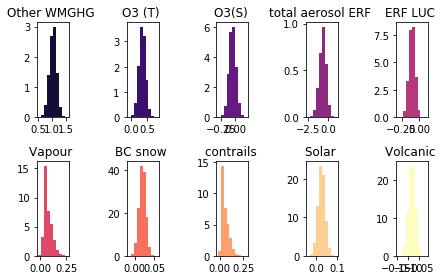

In [6]:
counter=1
for key in other_forcings:
    plt.subplot(2,5,counter)
    plt.hist(forcing_dict[key]["deviations"],density=True,color=cm.magma(counter/10.))
    plt.title(key)
    counter+=1
plt.tight_layout()

Now check to make sure the distribution of all forcings looks OK:

The mean is 0.6025553035296736


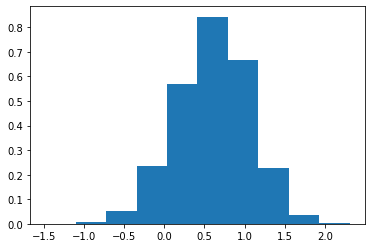

In [7]:
#all_forcings=np.zeros((len(other_forcings),nsamp))
#for i in range(len(other_forcings)):
 #   all_forcings[i]=forcing_dict[other_forcings[i]]["deviations"]
#dF_other=np.sum(all_forcings,axis=0)
dF_other=generate_dF()
n,bins,patches=plt.hist(dF_other,density=True)
print("The mean is", np.mean(dF_other))

For a putative value of $S_{hist}$, the energy balance model dictates a distribution of $\Delta T_{model}$.  We can compare this to the actual observed temperature change $\Delta T = 1 K$.  

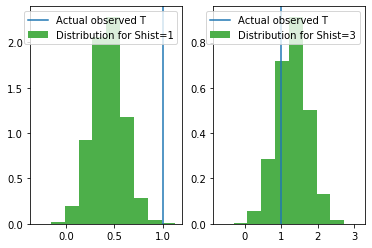

In [8]:
Shist=1.
dF_other=generate_dF()
values=Shist*(dF_CO2+dF_other-dN)/F2x + dT_error
plt.subplot(1,2,1)
n,bins,patches=plt.hist(values,color=cm.Set1(.3),density=True,label="Distribution for Shist=1")
plt.axvline(dT,label="Actual observed T")
plt.legend()

Shist=3.
dF_other=generate_dF()
values=Shist*(dF_CO2+dF_other-dN)/F2x + dT_error
plt.subplot(1,2,2)
n,bins,patches=plt.hist(values,color=cm.Set1(.3),density=True,label="Distribution for Shist=3")
plt.axvline(dT,label="Actual observed T")
plt.legend()

From this, we can see that $S_{hist}=3$ is more likely than $S_{hist}=1$, because the observed $\Delta T$ lies closer to the center of the resulting $\Delta T_{model}$ distribution.  Now, we loop over possible values of $S_{hist}$ and calculate the resulting likelihood, defined as the kernel density of Monte Carlo samples of $\Delta T_{model}$ evaluated at $\Delta T_{obs} = 1.0 K$.

In [9]:
Shist_values=np.linspace(0,8,1000)
likelihood=[]
for Shist in Shist_values:
    dF_other=generate_dF() #Do we need to re-sample DF, DT_error, DN every time?
    
    values=Shist*(dF_CO2+dF_other-dN)/F2x + dT_error
    kde = stats.gaussian_kde(values) 
    likelihood+=[float(kde(dT))]

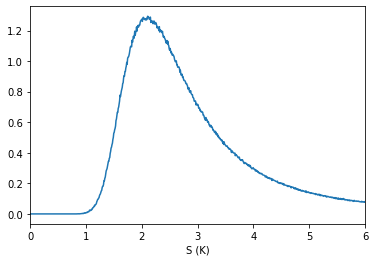

In [10]:
plt.plot(Shist_values,likelihood)
set_limits=plt.xlim(0,6)
xlab=plt.xlabel("S (K)")

In [11]:
print("The most likely value of S_hist is "+ str(Shist_values[np.argmax(likelihood)]))

The most likely value of S_hist is 2.106106106106106


In [12]:
samples=np.random.choice(Shist_values,size=100,p=likelihood/np.sum(likelihood),replace=True)
interpolation = "nearest"
print("5th percentile",np.percentile(samples, 5, interpolation=interpolation),)
print("95th percentile",np.percentile(samples, 95, interpolation=interpolation),)

5th percentile 1.6656656656656657
95th percentile 6.022022022022022
